# How Safe Is SF Now? A 20-Year Crime Retrospective

Crime often feels like a constant. But has San Francisco actually become more or less dangerous over time? Using over two decades of crime data, we take a closer look at how patterns have shifted — both in terms of volume and geography.

This story draws on a publicly available dataset from the San Francisco Police Department, covering over two decades of reported crimes from 2003 to 2024. The data includes incident-level records with information on date, time, location, police district, and crime category. For this analysis, we focus specifically on a subset of offenses often referred to as “focus crimes” — including assault, burglary, robbery, larceny/theft, drug violations, and similar high-impact categories. By analyzing these incidents across time and space, we aim to better understand how the city’s safety landscape has evolved — and where risk still lives.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import calmap  
import scipy.stats as stats
from scipy.stats import pearsonr
import geopandas as gpd  
from shapely.geometry import Point
import folium
from folium.plugins import HeatMap
from folium import FeatureGroup, LayerControl
import powerlaw  
from itertools import combinations
from math import radians, cos, sin, asin, sqrt
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, Legend, LegendItem
from bokeh.palettes import Category20
from bokeh.layouts import layout
from bokeh.io import curdoc, output_file, save

# if not installed, then run the following command:
# pip install pandas numpy matplotlib seaborn calmap geopandas folium powerlaw bokeh


In [2]:
# Load the dataset
file_path = r'sf_cleaned.csv'
df = pd.read_csv(file_path)

In [3]:
# Display basic info
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945085 entries, 0 to 2945084
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   incident_number   int64  
 1   category          object 
 2   date              object 
 3   time              object 
 4   day_of_week       object 
 5   police_district   object 
 6   longitude         float64
 7   latitude          float64
 8   year              int64  
 9   month             object 
 10  hour              int64  
 11  day of the month  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 269.6+ MB
None


In [4]:
# Define the focus crime categories
focus_crimes = [
    'WEAPON LAWS', 'PROSTITUTION', 'ROBBERY', 'BURGLARY', 'ASSAULT',
    'DRUG/NARCOTIC', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY'
]

# Filter for only the focus crimes
df_focus = df[df['category'].isin(focus_crimes)].copy()

# Total Reported Crime by Year

C:\Users\arund\AppData\Local\Temp\ipykernel_1984\516642875.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Oranges')


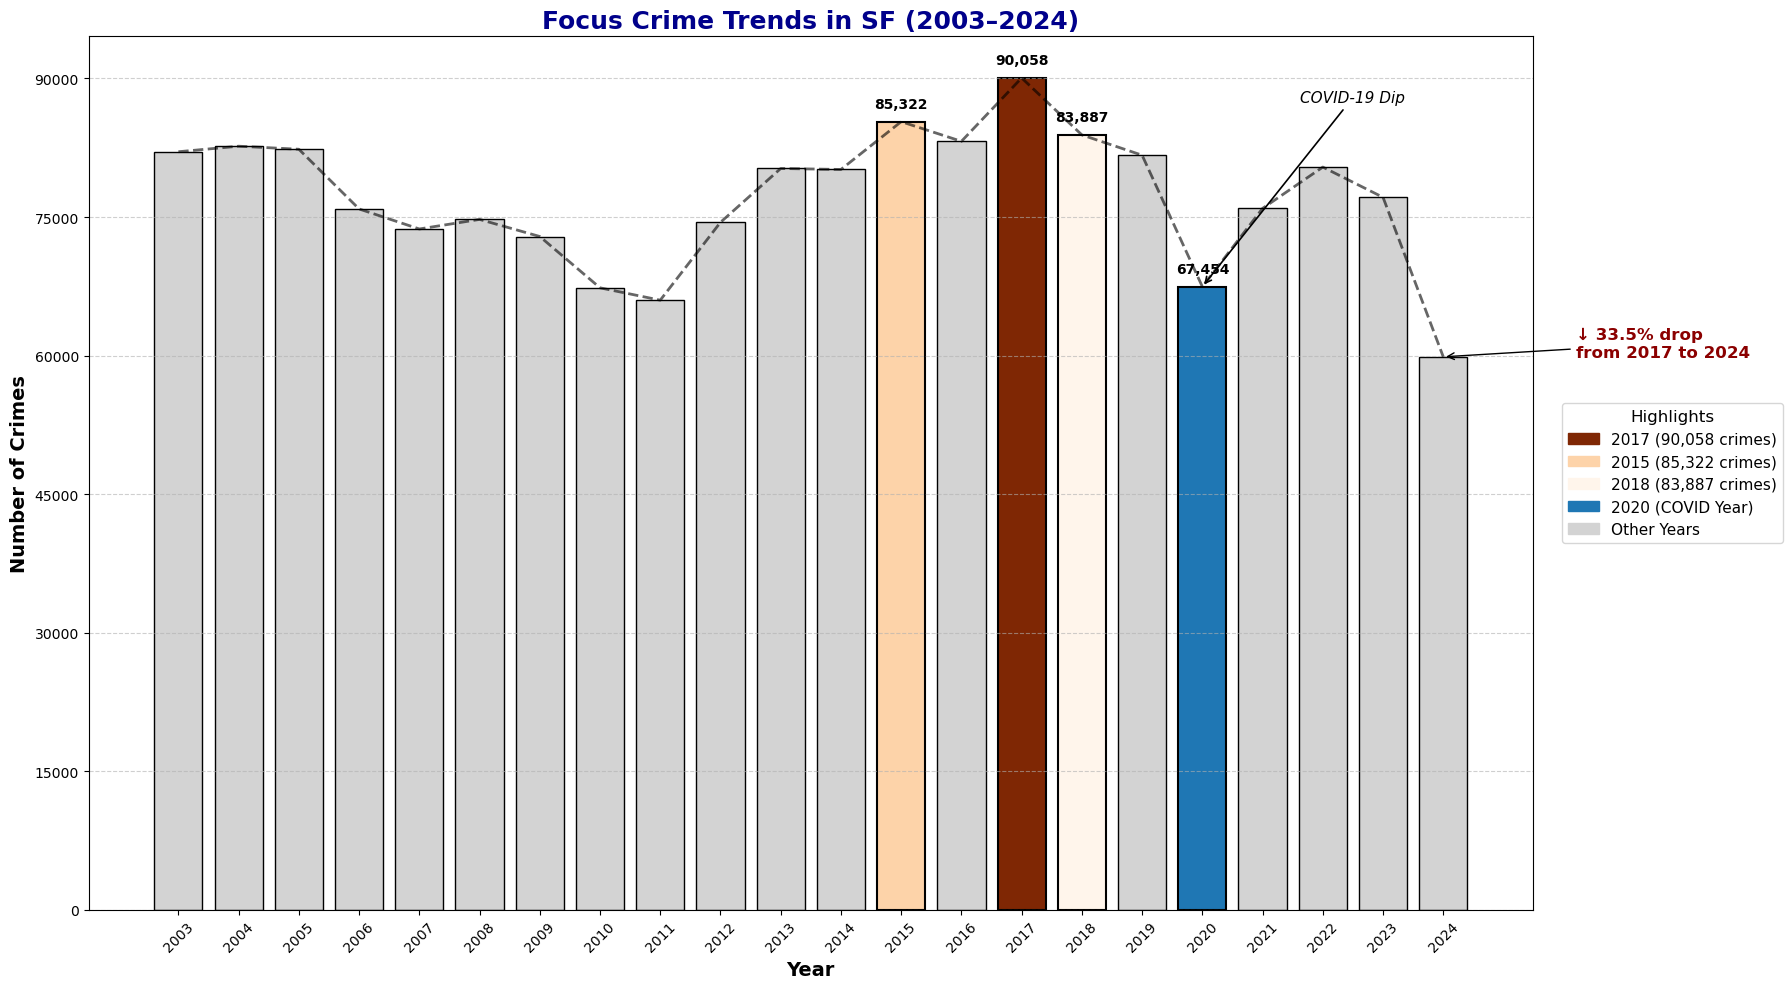

In [6]:
df_focus['date'] = pd.to_datetime(df_focus['date'])
df_focus['year'] = df_focus['date'].dt.year
year_counts = df_focus['year'].value_counts().sort_index()
top_3_years = year_counts.sort_values(ascending=False).head(3)
top_3_indices = top_3_years.index.tolist()
covid_year = 2020
covid_color = '#1f77b4'
norm = Normalize(vmin=min(top_3_years.values), vmax=max(top_3_years.values))
cmap = cm.get_cmap('Oranges')

fig, ax = plt.subplots(figsize=(18, 10))
plt.subplots_adjust(right=0.85)

for i, (year, count) in enumerate(year_counts.items()):
    if year == covid_year:
        bar = ax.bar(str(year), count, color=covid_color, edgecolor='black', linewidth=1.5)
        ax.text(i, count + 1500, f"{count:,}", ha='center', fontsize=10, fontweight='bold')
    elif year in top_3_indices:
        color = cmap(norm(count))
        bar = ax.bar(str(year), count, color=color, edgecolor='black', linewidth=1.5)
        ax.text(i, count + 1500, f"{count:,}", ha='center', fontsize=10, fontweight='bold')
    else:
        ax.bar(str(year), count, color='lightgray', edgecolor='black')

ax.plot(year_counts.index.astype(str), year_counts.values, color='black', linestyle='--', linewidth=2, alpha=0.6)

covid_count = year_counts[covid_year]
ax.annotate('COVID-19 Dip',
            xy=(str(covid_year), covid_count),
            xytext=(i - 1.5, covid_count + 20000),  
            arrowprops=dict(facecolor='gray', arrowstyle='->', linewidth=1.2),
            fontsize=11,
            ha='center',
            fontstyle='italic',
            color='black')

peak_year = top_3_years.idxmax()
peak_val = top_3_years.max()
latest_year = year_counts.index.max()
latest_val = year_counts[latest_year]
perc_change = ((peak_val - latest_val) / peak_val) * 100

ax.annotate(f"↓ {perc_change:.1f}% drop\nfrom {peak_year} to {latest_year}",
            xy=(str(latest_year), latest_val),
            xytext=(len(year_counts) + 1.2, latest_val),  
            arrowprops=dict(facecolor='darkred', arrowstyle='->'),
            fontsize=12, color='darkred', fontweight='bold', ha='left')

ax.set_title('Focus Crime Trends in SF (2003–2024)',
             fontsize=18, fontweight='bold', color='darkblue')
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Crimes', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45, labelsize=10)

ax.yaxis.set_major_locator(MaxNLocator(nbins='auto', integer=True, prune=None))
ax.tick_params(axis='y', labelsize=10)

ax.grid(axis='y', linestyle='--', alpha=0.6)
legend_patches = [
    mpatches.Patch(color=cmap(norm(v)), label=f"{k} ({v:,} crimes)") for k, v in top_3_years.items()
]
legend_patches.append(mpatches.Patch(color=covid_color, label="2020 (COVID Year)"))
legend_patches.append(mpatches.Patch(color='lightgray', label='Other Years'))

ax.legend(handles=legend_patches,
          title="Highlights",
          fontsize=11,
          title_fontsize=12,
          loc='center left',
          bbox_to_anchor=(1.02, 0.5),
          borderaxespad=0)

plt.tight_layout()
plt.show()


Over the past two decades, San Francisco’s reported focus crimes — offenses like assault, burglary, larceny, vandalism, and drug violations — have followed a trajectory that tells a deeper story than a simple rise or fall. In 2017, these crimes reached their apex, recording just over 90,000 incidents. It was a year that stood out not just statistically, but socially — a time when the city grappled with intense housing pressures, growing inequality, and shifting enforcement priorities. Whether this spike reflected an actual surge in criminal activity or a shift in reporting and policing remains an open question, but the data leaves little doubt: 2017 was the city’s most crime-heavy year in two decades. What followed, however, is perhaps more surprising. Crime rates began to drop in the years after 2017, and then in 2020, they plunged. That dramatic dip aligns with the onset of the COVID-19 pandemic — a moment when San Francisco, like much of the world, went into lockdown. With businesses shuttered and public life on pause, crime opportunities likely diminished. This sharp but temporary decrease in 2020 appears more as a disruption than a correction — a data blip grounded in real-world behavioral change.

The real story emerges in what came next. Unlike some cities where crime rebounded post-pandemic, San Francisco’s focus crime numbers remained lower. By 2024, they had dropped more than 33% from their 2017 peak. This trend raises compelling questions: Has the city become genuinely safer? Are we witnessing the effects of long-term policy shifts, technological deterrents, or evolving community dynamics? Or could changes in crime reporting and classification be influencing the apparent decline? While the dataset alone can’t answer these questions definitively, the pattern is clear. San Francisco’s focus crime rates are trending down — not just in the short term, but across nearly a decade. But if crime is falling overall, a more urgent question remains: where is it still happening? Are some neighborhoods still carrying a disproportionate share of the burden? To understand that, we need to move beyond the timeline — and turn to the map.

# Where is crime concentrated in the city?

In [7]:
# Round lat/lon into bins
def bin_coords(df, precision=3):
    df['lat_bin'] = df['latitude'].round(precision)
    df['lon_bin'] = df['longitude'].round(precision)
    return set(zip(df['lat_bin'], df['lon_bin']))

# Filter & bin for 2017 and 2024
df_2017 = df_focus[df_focus['year'] == 2017].dropna(subset=['latitude', 'longitude'])
df_2024 = df_focus[df_focus['year'] == 2024].dropna(subset=['latitude', 'longitude'])

bins_2017 = bin_coords(df_2017)
bins_2024 = bin_coords(df_2024)

# Set logic
both_years = bins_2017 & bins_2024
only_2017 = bins_2017 - bins_2024
only_2024 = bins_2024 - bins_2017

# Map init
m = folium.Map(location=[37.7749, -122.4194], zoom_start=12, tiles='CartoDB positron')

# Helper to add circle markers
def plot_bins(bin_set, color, label, group):
    for lat, lon in bin_set:
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6,
            tooltip=label
        ).add_to(group)

# Create layer groups
layer_both = FeatureGroup(name="Persistent Hotspots (2017 & 2024)")
layer_improved = FeatureGroup(name="Hotspots in 2017, now Safer")
layer_new = FeatureGroup(name="New Hotspots in 2024")

# Plot each set
plot_bins(both_years, '#C44536', 'Persistent Hotspot', layer_both)
plot_bins(only_2017, '#E07A5F', 'Used to be Unsafe', layer_improved)
plot_bins(only_2024, '#3D5A80', 'New in 2024', layer_new)

# Add to map
layer_both.add_to(m)
layer_improved.add_to(m)
layer_new.add_to(m)
LayerControl(collapsed=False).add_to(m)

# Save the map
m.save("focus_crime_hotspot_comparison.html")
m

While San Francisco’s focus crime totals have clearly declined since their peak in 2017, the more interesting question is: where has that change actually happened? After all, citywide trends don’t tell us whether the same neighborhoods are improving — or simply being replaced by new ones. This map offers a spatial breakdown of how crime patterns have shifted across the city. It compares geolocated incidents from 2017 and 2024 using three categories: locations where crime was reported in both years (persistent hotspots), locations that only appeared in 2017 (now improved), and locations that only appear in 2024 (newly unsafe). What emerges is a portrait of uneven progress.

Persistent hotspots — marked in red — are heavily clustered in downtown San Francisco, especially around the Tenderloin, SoMa, and the eastern Mission. These are neighborhoods that saw significant activity in 2017 and continue to report crimes at similar locations in 2024. In short, while the overall number of crimes may have dropped, these zones remain repeatedly affected. They represent the core of the city’s long-standing public safety challenges. At the same time, a large number of locations — shown in orange — were active in 2017 but are no longer present in the 2024 dataset. These now-improved areas stretch across the western half of the city and include much of the Richmond and Sunset districts, as well as southern residential neighborhoods. The absence of new incidents in these zones suggests a measurable reduction in crime footprint — not just in numbers, but in space. But crime hasn't disappeared — it's moved. A third set of markers, shown in blue, represents new hotspots that didn’t exist in 2017 but have emerged in 2024. These points are scattered along the northern waterfront, the Bayview area, and other fringe zones of the city. They illustrate a quiet reshaping of risk: some areas have stabilized, while others are stepping into the spotlight.

While the hotspot map revealed how specific locations have changed over time, it raises a broader question of structure and responsibility: how does the burden of crime vary across San Francisco’s official police districts? These districts are more than lines on a map — they define how the city deploys officers, responds to calls, and engages communities. In this final view, we move beyond individual incidents and look at the cumulative impact. By analyzing the total number and types of focus crimes across districts, we begin to see how the geography of crime intersects with the geography of governance — and which districts consistently carry more weight in keeping the city safe.

# District Disparities: Mapping the Weight of Crime in San Francisco

In [8]:
# === Step 1: Prepare data ===
df_focus['year'] = pd.to_datetime(df_focus['date']).dt.year
focus_crimes = [
    'WEAPON LAWS', 'PROSTITUTION', 'ROBBERY', 'BURGLARY', 'ASSAULT',
    'DRUG/NARCOTIC', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY'
]
df_focus = df_focus[df_focus['category'].isin(focus_crimes)]

# === Step 2: Group and pivot ===
grouped = df_focus.groupby(['police_district', 'category']).size().unstack(fill_value=0)
grouped = grouped.sort_index()

districts = grouped.index.tolist()
categories = grouped.columns.tolist()
source_data = {'district': districts}
for cat in categories:
    source_data[cat] = grouped[cat].tolist()

source = ColumnDataSource(data=source_data)

# === Step 3: Create figure ===
colors = Category20[20][:len(categories)]  
p = figure(x_range=districts,
           title="Total Focus Crimes by District and Category",
           width=1250, height=700,
           tools="pan,wheel_zoom,box_zoom,reset,hover,save",
           toolbar_location="above")

renderers = p.vbar_stack(categories, x='district', width=0.9, color=colors,
                         source=source, legend_label=categories)

# === Step 4: Hover Tool ===
hover = HoverTool(tooltips="""
    <div style="padding:4px 8px">
        <strong>District:</strong> @district<br>
        <strong>Category:</strong> $name<br>
        <strong>Total Crimes:</strong> @$name
    </div>
""")
p.add_tools(hover)

# === Step 5: Styling ===
p.y_range.start = 0
p.xgrid.grid_line_color = "#eeeeee"
p.ygrid.grid_line_color = "#eeeeee"
p.outline_line_color = None

# Axis styling
p.yaxis.axis_label = "Total Crimes"
p.yaxis.axis_label_text_font_size = "12pt"
p.yaxis.major_label_text_font_size = "10pt"
p.yaxis.axis_line_color = "#cccccc"

p.xaxis.axis_label = "Police District"
p.xaxis.axis_label_text_font_size = "12pt"
p.xaxis.major_label_orientation = 1.0
p.xaxis.major_label_text_font_size = "10pt"
p.xaxis.axis_line_color = "#cccccc"

# Title styling
p.title.align = "center"
p.title.text_font_size = "16pt"
p.title.text_font_style = "bold"
p.legend.visible = False
legend_items = [LegendItem(label=cat, renderers=[r]) for cat, r in zip(categories, renderers)]
custom_legend = Legend(items=legend_items, location="center", spacing=6)
custom_legend.title = "Crime Categories"
custom_legend.title_text_font_size = "12pt"
custom_legend.label_text_font_size = "10pt"
custom_legend.glyph_width = 16
custom_legend.label_standoff = 8
custom_legend.click_policy = "hide"
p.add_layout(custom_legend, 'right')

# === Step 6: Layout & Show ===
layout_plot = layout([[p]], sizing_mode='stretch_width')
curdoc().add_root(layout_plot)
show(layout_plot)

# Save the plot as an HTML file
output_file("focus_crime_districts.html")
save(layout_plot, filename="focus_crime_districts.html")



'd:\\spring 2025\\social data analysis and viusalisation\\Social_data_analysis_visulaisation_Assignment_2\\focus_crime_districts.html'

While San Francisco’s crime story has shifted dramatically in time and space, its administrative backbone—the police district—remains a constant in the city’s public safety infrastructure. In this view, we zoom out to examine the total burden of focus crimes from 2003 to 2024, distributed across the city’s official police districts. The chart reveals a landscape of deep imbalance. Districts like Southern, Central, and Mission consistently bear the highest total crime loads, with Southern emerging as a particularly overburdened hotspot. What’s striking is not just the quantity, but the composition: theft-related crimes like larceny/theft, vehicle theft, and burglary dominate nearly every district, but the prominence of categories like drug/narcotic violations in Tenderloin, assault in Mission, and robbery in Northern illustrate how the burden isn’t just unequal—it’s unique. Each district contends with a distinct blend of challenges, shaped by its geography, demographics, and policing strategies. On the other end of the spectrum, districts like Park, Richmond, and Taraval reflect relatively lower crime totals, though they’re not immune from the same crime types. The visual contrast reinforces the idea that public safety is experienced unequally across the city, with some neighborhoods absorbing far more risk than others.

This final view brings the structural layer of the crime conversation into focus. These aren’t just numbers—they are reflective of how the city allocates its attention and resources, and which communities are asked to bear the greatest cost of urban insecurity. As San Francisco looks ahead, this geographic inequity must be central to conversations about policing, prevention, and reform.

# Conclusion

Over the past 20 years, San Francisco’s focus crime landscape has changed — not just in scale, but in shape. The city has seen a meaningful decline in overall incidents, especially since the 2017 peak and the COVID-era disruption. But that drop is not evenly felt. Some neighborhoods remain persistently vulnerable, while others have stabilized or faded from the crime map. And at the district level, the imbalance is stark: a few areas carry much of the city’s crime burden — and with it, the responsibility for public safety response. What emerges is not just a picture of crime, but of how risk and accountability are distributed in an evolving city. If San Francisco wants to build on these improvements, it must reckon with the geographies of persistence, emergence, and neglect. Crime may be down overall — but for the communities still absorbing its impact, the work is far from over.

